In [1]:
# ======================================================
# 1. SETUP & REPRODUCIBILITY
# ======================================================
import os
import random
import numpy as np
import tensorflow as tf

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# ======================================================
# 2. MOUNT DRIVE & IMPORTS
# ======================================================
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:

from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns

# ======================================================
# 3. PARAMETERS
# ======================================================
IMAGE_DIR = '/content/drive/MyDrive/UCMerced_LandUse/Images'
IMG_SIZE = (128, 128)
NUM_CLASSES = 21
BATCH_SIZE = 32
EPOCHS = 150


In [3]:

# ======================================================
# 4. DATA LOADING
# ======================================================
def load_data(image_dir):
    images, labels = [], []
    for cls in os.listdir(image_dir):
        cls_path = os.path.join(image_dir, cls)
        if os.path.isdir(cls_path):
            for img in os.listdir(cls_path):
                path = os.path.join(cls_path, img)
                img_arr = tf.keras.preprocessing.image.img_to_array(
                    tf.keras.preprocessing.image.load_img(path, target_size=IMG_SIZE)
                )
                images.append(img_arr)
                labels.append(cls)
    return np.array(images) / 255.0, np.array(labels)

images, labels = load_data(IMAGE_DIR)


In [4]:

# ======================================================
# 5. ENCODING & SPLIT (IMPORTANT)
# ======================================================
encoder = LabelEncoder()
labels_encoded = encoder.fit_transform(labels)
labels_cat = tf.keras.utils.to_categorical(labels_encoded, NUM_CLASSES)

X_train, X_test, y_train, y_test = train_test_split(
    images, labels_cat, test_size=0.2, stratify=labels_encoded, random_state=SEED
)

# ======================================================
# 6. DATA BALANCING (TRAIN ONLY)
# ======================================================
def balance_data(X, y):
    classes = np.argmax(y, axis=1)
    max_samples = max(np.bincount(classes))

    X_bal, y_bal = [], []
    for c in np.unique(classes):
        idx = np.where(classes == c)[0]
        X_c, y_c = X[idx], y[idx]

        X_res, y_res = resample(
            X_c, y_c, replace=True,
            n_samples=max_samples, random_state=SEED
        )
        X_bal.append(X_res)
        y_bal.append(y_res)

    return np.vstack(X_bal), np.vstack(y_bal)

X_train, y_train = balance_data(X_train, y_train)

In [6]:

# ======================================================
# 7. FUZZY MEMBERSHIP LAYER (FINAL)
# ======================================================
class FuzzyMembershipLayer(Layer):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

    def build(self, input_shape):
        self.centers = self.add_weight(
            shape=(input_shape[-1], self.num_classes),
            initializer="glorot_uniform",
            trainable=True
        )

    def call(self, inputs):
        x = tf.nn.l2_normalize(inputs, axis=1)
        c = tf.nn.l2_normalize(self.centers, axis=0)
        return tf.nn.softmax(tf.matmul(x, c))

# ======================================================
# 8. MODEL DEFINITION (PROPOSED MODEL)
# ======================================================
def build_model():
    base = VGG19(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
    for layer in base.layers[:15]:
        layer.trainable = False

    x = GlobalAveragePooling2D()(base.output)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    output = FuzzyMembershipLayer(NUM_CLASSES)(x)

    model = Model(base.input, output)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

model = build_model()
model.summary()




80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 20,299,840 (77.44 MB)

 Trainable params: 12,073,472 (46.06 MB)

 Non-trainable params: 8,226,368 (31.38 MB)

In [10]:

# ======================================================
# 9. TRAINING
# ======================================================
datagen = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.3,
    horizontal_flip=True
)

callbacks = [
    EarlyStopping(patience=15, restore_best_weights=True),
    ReduceLROnPlateau(patience=5, factor=0.5)
]





In [11]:


# ======================================================
# 5.b K-FOLD CROSS-VALIDATION
# ======================================================
from sklearn.model_selection import StratifiedKFold

K = 5
skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=SEED)

labels_train_int = np.argmax(y_train, axis=1)

fold_accuracies = []

print(f"\nStarting {K}-Fold Cross-Validation...\n")

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, labels_train_int)):
    print(f"Fold {fold+1}/{K}")

    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]

    model_kf = build_model()

    history_kf = model_kf.fit(
        datagen.flow(X_tr, y_tr, batch_size=BATCH_SIZE),
        validation_data=(X_val, y_val),
        epochs=EPOCHS,
        callbacks=callbacks,
        verbose=0
    )

    scores = model_kf.evaluate(X_val, y_val, verbose=0)
    fold_accuracies.append(scores[1])

    print(f"Validation Accuracy: {scores[1]:.4f}\n")

print(f"Mean CV Accuracy: {np.mean(fold_accuracies):.4f}")
print(f"Std CV Accuracy: {np.std(fold_accuracies):.4f}")




Starting 5-Fold Cross-Validation...

Fold 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Validation Accuracy: 0.9821

Fold 2/5
Validation Accuracy: 0.9851

Fold 3/5
Validation Accuracy: 0.9643

Fold 4/5
Validation Accuracy: 0.9792

Fold 5/5
Validation Accuracy: 0.9821

Mean CV Accuracy: 0.9786
Std CV Accuracy: 0.0074


In [12]:
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 23s 336ms/step - accuracy: 0.3155 - loss: 2.9716 - val_accuracy: 0.6643 - val_loss: 2.8517 - learning_rate: 1.0000e-04
Epoch 2/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 189ms/step - accuracy: 0.7468 - loss: 2.7816 - val_accuracy: 0.8381 - val_loss: 2.6717 - learning_rate: 1.0000e-04
Epoch 3/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 183ms/step - accuracy: 0.8801 - loss: 2.6669 - val_accuracy: 0.8857 - val_loss: 2.5075 - learning_rate: 1.0000e-04
Epoch 4/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 170ms/step - accuracy: 0.9469 - loss: 2.5895 - val_accuracy: 0.8905 - val_loss: 2.4029 - learning_rate: 1.0000e-04
Epoch 5/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 190ms/step - accuracy: 0.9552 - loss: 2.5362 - val_accuracy: 0.9190 - val_loss: 2.3403 - learning_rate: 1.0000e-04
Epoch 6/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 189ms/step - accuracy: 0.9739 - loss: 2.4982 - val_accuracy: 0.9333 - val_loss: 2.3016 - learning_rate: 1.0000e-04
Epoch 7/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 175ms/step 

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step
                   precision    recall  f1-score   support

     agricultural       1.00      0.95      0.97        20
         airplane       1.00      1.00      1.00        20
  baseballdiamond       0.90      0.95      0.93        20
            beach       0.95      1.00      0.98        20
        buildings       0.86      0.90      0.88        20
        chaparral       0.95      1.00      0.98        20
 denseresidential       0.76      0.80      0.78        20
           forest       1.00      1.00      1.00        20
          freeway       1.00      1.00      1.00        20
       golfcourse       0.94      0.85      0.89        20
           harbor       1.00      1.00      1.00        20
     intersection       1.00      0.95      0.97        20
mediumresidential       0.79      0.95      0.86        20
   mobilehomepark       1.00      0.90      0.95        20
         overpass       0.95      1.00      0.98        20
       parking

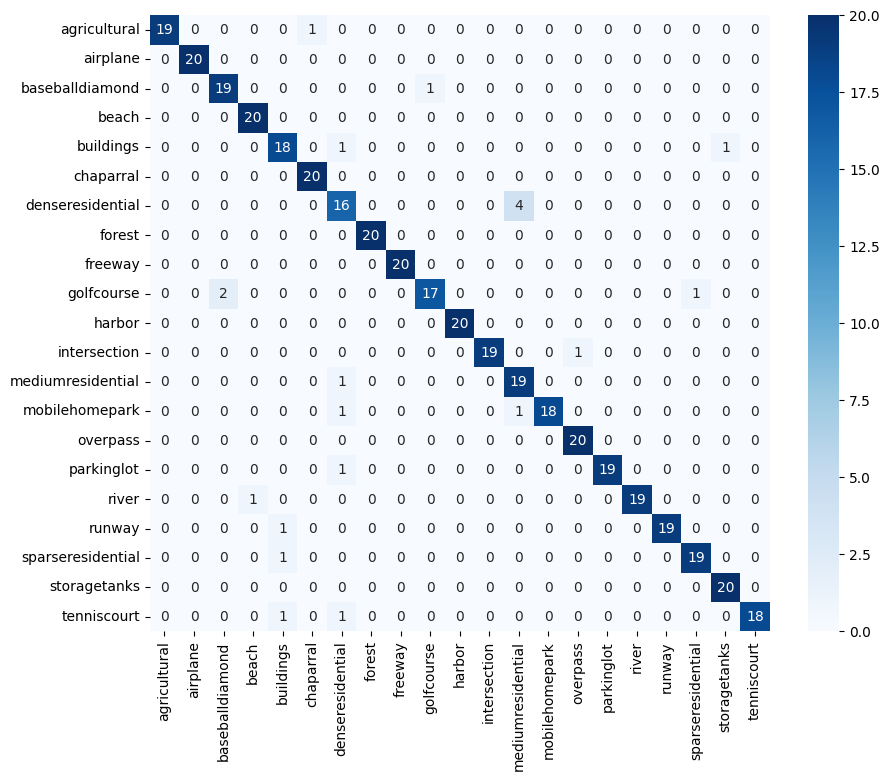

In [13]:

# ======================================================
# 10. EVALUATION
# ======================================================
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred, target_names=encoder.classes_))

plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_true, y_pred),
            xticklabels=encoder.classes_,
            yticklabels=encoder.classes_,
            annot=True, fmt='d', cmap='Blues')
plt.show()

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step


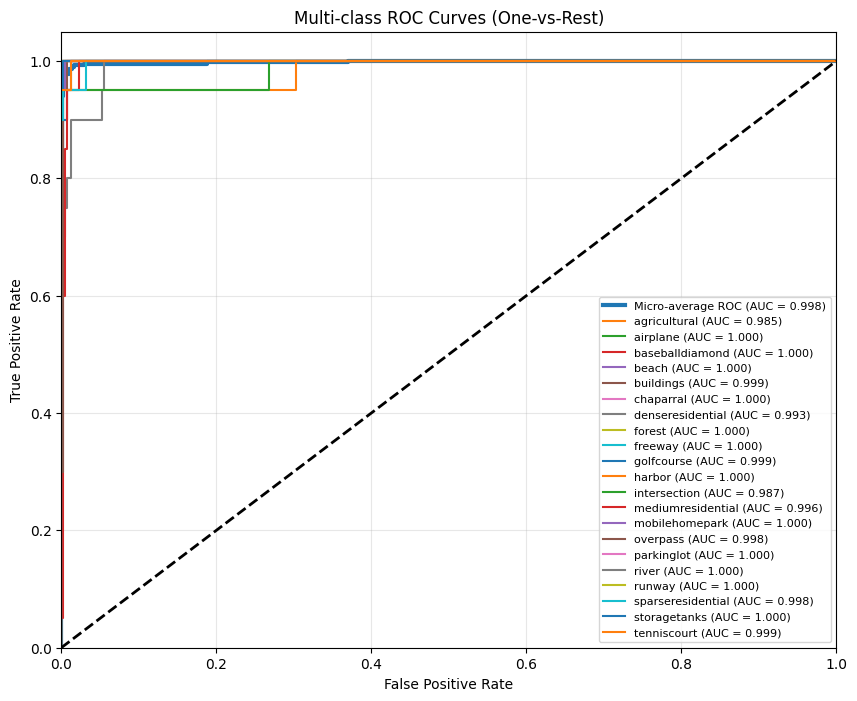

In [14]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# ============================================
# ROC CURVES (MULTI-CLASS - ONE VS REST)
# ============================================

# Probabilités prédites (مهم: بدون argmax)
y_score = model.predict(X_test)

# تحويل y_true إلى format binaire
y_test_bin = label_binarize(y_true, classes=range(NUM_CLASSES))

fpr = {}
tpr = {}
roc_auc = {}

# ROC لكل classe
for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ROC micro-average
fpr["micro"], tpr["micro"], _ = roc_curve(
    y_test_bin.ravel(), y_score.ravel()
)
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# ============================================
# PLOT
# ============================================
plt.figure(figsize=(10, 8))

# Micro-average
plt.plot(
    fpr["micro"], tpr["micro"],
    label=f"Micro-average ROC (AUC = {roc_auc['micro']:.3f})",
    linewidth=3
)

# ROC لكل كلاس
for i in range(NUM_CLASSES):
    plt.plot(
        fpr[i], tpr[i], lw=1.5,
        label=f"{encoder.classes_[i]} (AUC = {roc_auc[i]:.3f})"
    )

# Random classifier
plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-class ROC Curves (One-vs-Rest)")
plt.legend(loc="lower right", fontsize=8)
plt.grid(alpha=0.3)
plt.show()
